# **Домашнее задание 8**

Реализовать синтезирование лиц из LFW с помощью DCGAN. Библиотеки: [Python, Tensorflow]

## Переключение версии TensorFlow

In [2]:
!pip install tensorflow==1.14
!pip install scipy==1.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109.3 MB 54 kB/s 
     |████████████████████████████████| 50 kB 7.4 MB/s 
     |████████████████████████████████| 3.1 MB 67.1 MB/s 
     |████████████████████████████████| 488 kB 71.4 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.2+zzzcolab20220719082949
    Uninstalling tensorflow-2.8.2+zzzcolab20220719082949:
      Successfully uninstalled tensorflow-2.8.2+zzzcolab20220719082949
ERROR: pip's dependency resolver does not currently ta

In [3]:
import tensorflow as tf
import numpy as np
import urllib
import tarfile
import os
import matplotlib.pyplot as plt
%matplotlib inline
from imageio import imread, imsave, mimsave
from scipy.misc import imresize
import glob

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

## Загрузка датасета LFW

In [4]:
url = 'http://vis-www.cs.umass.edu/lfw/lfw.tgz'
filename = 'lfw.tgz'
directory = 'lfw_imgs'
new_dir = 'lfw_new_imgs'
 
if not os.path.isdir(new_dir):
    os.mkdir(new_dir)
    
    if not os.path.isdir(directory):
        if not os.path.isfile(filename):
            urllib.request.urlretrieve(url, filename)
        tar = tarfile.open(filename, 'r:gz')
        tar.extractall(path=directory)
        tar.close()
    
    count = 0
    for dir_, _, files in os.walk(directory):
        for file_ in files:
            img = imread(os.path.join(dir_, file_))
            imsave(os.path.join(new_dir, '%d.png' % count), img)
            count += 1


In [5]:
dataset = 'lfw_new_imgs'
images = glob.glob(os.path.join(dataset, '*.*')) 
print(len(images))

13233


In [6]:
batch_size = 100
z_dim = 100
WIDTH = 64
HEIGHT = 64
 
OUTPUT_DIR = 'samples_' + dataset
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)
 
X = tf.placeholder(dtype=tf.float32, shape=[None, HEIGHT, WIDTH, 3], name='X')
noise = tf.placeholder(dtype=tf.float32, shape=[None, z_dim], name='noise')
is_training = tf.placeholder(dtype=tf.bool, name='is_training')
 
def lrelu(x, leak=0.2):
    return tf.maximum(x, leak * x)
 
def sigmoid_cross_entropy_with_logits(x, y):
    return tf.nn.sigmoid_cross_entropy_with_logits(logits=x, labels=y)

## Deep Convolutional GAN (DCGAN)

In [7]:
def generator(z, is_training=is_training):
    momentum = 0.9
    with tf.variable_scope('generator', reuse=None):
        d = 4
        h0 = tf.layers.dense(z, units=d * d * 512)
        h0 = tf.reshape(h0, shape=[-1, d, d, 512])
        h0 = tf.nn.relu(tf.contrib.layers.batch_norm(h0, is_training=is_training, decay=momentum))
        
        h1 = tf.layers.conv2d_transpose(h0, kernel_size=5, filters=256, strides=2, padding='same')
        h1 = tf.nn.relu(tf.contrib.layers.batch_norm(h1, is_training=is_training, decay=momentum))
        
        h2 = tf.layers.conv2d_transpose(h1, kernel_size=5, filters=128, strides=2, padding='same')
        h2 = tf.nn.relu(tf.contrib.layers.batch_norm(h2, is_training=is_training, decay=momentum))
        
        h3 = tf.layers.conv2d_transpose(h2, kernel_size=5, filters=64, strides=2, padding='same')
        h3 = tf.nn.relu(tf.contrib.layers.batch_norm(h3, is_training=is_training, decay=momentum))
        
        h4 = tf.layers.conv2d_transpose(h3, kernel_size=5, filters=3, strides=2, padding='same', activation=tf.nn.tanh, name='g')
        return h4

def discriminator(image, reuse=None, is_training=is_training):
    momentum = 0.9
    with tf.variable_scope('discriminator', reuse=reuse):
        h0 = lrelu(tf.layers.conv2d(image, kernel_size=5, filters=64, strides=2, padding='same'))
        
        h1 = tf.layers.conv2d(h0, kernel_size=5, filters=128, strides=2, padding='same')
        h1 = lrelu(tf.contrib.layers.batch_norm(h1, is_training=is_training, decay=momentum))
        
        h2 = tf.layers.conv2d(h1, kernel_size=5, filters=256, strides=2, padding='same')
        h2 = lrelu(tf.contrib.layers.batch_norm(h2, is_training=is_training, decay=momentum))
        
        h3 = tf.layers.conv2d(h2, kernel_size=5, filters=512, strides=2, padding='same')
        h3 = lrelu(tf.contrib.layers.batch_norm(h3, is_training=is_training, decay=momentum))
        
        h4 = tf.contrib.layers.flatten(h3)
        h4 = tf.layers.dense(h4, units=1)
        return tf.nn.sigmoid(h4), h4

##Функция потерь

In [8]:
g = generator(noise)
d_real, d_real_logits = discriminator(X)
d_fake, d_fake_logits = discriminator(g, reuse=True)
 
vars_g = [var for var in tf.trainable_variables() if var.name.startswith('generator')]
vars_d = [var for var in tf.trainable_variables() if var.name.startswith('discriminator')]
 
loss_d_real = tf.reduce_mean(sigmoid_cross_entropy_with_logits(d_real_logits, tf.ones_like(d_real)))
loss_d_fake = tf.reduce_mean(sigmoid_cross_entropy_with_logits(d_fake_logits, tf.zeros_like(d_fake)))
loss_g = tf.reduce_mean(sigmoid_cross_entropy_with_logits(d_fake_logits, tf.ones_like(d_fake)))
loss_d = loss_d_real + loss_d_fake

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.


Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.


Instructions for updating:
Use keras.layers.flatten instead.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


##Функция оптимизации

In [9]:
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer_d = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5).minimize(loss_d, var_list=vars_d)
    optimizer_g = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5).minimize(loss_g, var_list=vars_g)

##Функция чтения картинок

In [10]:
def read_image(path, height, width):
    image = imread(path)
    h = image.shape[0]
    w = image.shape[1]
    
    if h > w:
        image = image[h // 2 - w // 2: h // 2 + w // 2, :, :]
    else:
        image = image[:, w // 2 - h // 2: w // 2 + h // 2, :]    
    
    image = imresize(image, (height, width))
    return image / 255.

##Функции для синтеза картинок

In [11]:
def montage(images):    
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    if len(images.shape) == 4 and images.shape[3] == 3:
        m = np.ones(
            (images.shape[1] * n_plots + n_plots + 1,
             images.shape[2] * n_plots + n_plots + 1, 3)) * 0.5
    elif len(images.shape) == 4 and images.shape[3] == 1:
        m = np.ones(
            (images.shape[1] * n_plots + n_plots + 1,
             images.shape[2] * n_plots + n_plots + 1, 1)) * 0.5
    elif len(images.shape) == 3:
        m = np.ones(
            (images.shape[1] * n_plots + n_plots + 1,
             images.shape[2] * n_plots + n_plots + 1)) * 0.5
    else:
        raise ValueError('Could not parse image shape of {}'.format(images.shape))
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                m[1 + i + i * img_h:1 + i + (i + 1) * img_h,
                  1 + j + j * img_w:1 + j + (j + 1) * img_w] = this_img
    return m

##Обучение модели

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  # This is added back by InteractiveShellApp.init_path()


0 1.7605047 0.6832212


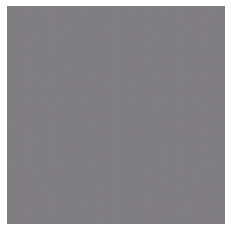

500 1.4580324 0.68710303


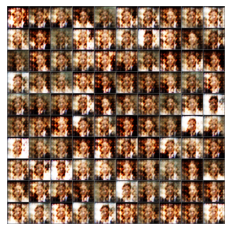

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
z_samples = np.random.uniform(-1.0, 1.0, [batch_size, z_dim]).astype(np.float32)
samples = []
loss = {'d': [], 'g': []}
 
offset = 0
for i in range(60000):
    n = np.random.uniform(-1.0, 1.0, [batch_size, z_dim]).astype(np.float32)
    
    offset = (offset + batch_size) % len(images)
    batch = np.array([read_image(img, HEIGHT, WIDTH) for img in images[offset: offset + batch_size]])
    batch = (batch - 0.5) * 2
    
    d_ls, g_ls = sess.run([loss_d, loss_g], feed_dict={X: batch, noise: n, is_training: True})
    loss['d'].append(d_ls)
    loss['g'].append(g_ls)
    
    sess.run(optimizer_d, feed_dict={X: batch, noise: n, is_training: True})
    sess.run(optimizer_g, feed_dict={X: batch, noise: n, is_training: True})
    sess.run(optimizer_g, feed_dict={X: batch, noise: n, is_training: True})
        
    if i % 500 == 0:
        print(i, d_ls, g_ls)
        gen_imgs = sess.run(g, feed_dict={noise: z_samples, is_training: False})
        gen_imgs = (gen_imgs + 1) / 2
        imgs = [img[:, :, :] for img in gen_imgs]
        gen_imgs = montage(imgs)
        plt.axis('off')
        plt.imshow(gen_imgs)
        imsave(os.path.join(OUTPUT_DIR, 'sample_%d.jpg' % i), gen_imgs)
        plt.show()
        samples.append(gen_imgs)
 
plt.plot(loss['d'], label='Discriminator')
plt.plot(loss['g'], label='Generator')
plt.legend(loc='upper right')
plt.savefig(os.path.join(OUTPUT_DIR, 'Loss.png'))
plt.show()
mimsave(os.path.join(OUTPUT_DIR, 'samples.gif'), samples, fps=10)